In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print("The target (0~16):\n", train_y[0:16])

11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
The target (0~16):
 [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]


# **Data Preparation**<p>
老慮到訓練時間，只採用3000筆資料

In [3]:
# Normalization
train_X = train_X / 255
test_X = test_X / 255
train_X = train_X[0:3000]
test_X = test_X[0:3000]

print("train_X:", train_X.shape)
print("test_X:", test_X.shape)
#print(train_X[29999, :, :])
#print(x_train[200:500, 29999])

# one-hot encoding for y_train and y_test
y_train_one_hot = np.zeros((10, 60000))
for i in range(len(train_y)):
    y_train_one_hot[train_y[i], i] = 1

y_test_one_hot = np.zeros((10, 10000))
for i in range(len(test_y)):
    y_test_one_hot[test_y[i], i] = 1

train_X: (3000, 28, 28)
test_X: (3000, 28, 28)


# **Activation Function**

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_derive(x):
    return x > 0

def sigmoid (x):  # for the hidden layer
    return np.exp(-np.logaddexp(0, -x))  # 對於值非常大的輸入有穩定的輸出
    # return 1 / (1 + np.exp(-x))  # 標準版本

def sigmoid_derive (x):  #微分後
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):  # for the output layer
    expon_x = np.exp(x)
    exponsum = np.sum(expon_x, axis=0, keepdims=True)  # 沿著row(垂直)做加總
    sofmax_x = expon_x / (exponsum + 1e-8)
    return sofmax_x

def tanh(x):
    return np.tanh(x)

def tanh_derive(x):
    return 1 - tanh(x) ** 2

def cross_entropy_loss(y_pred, y_true):
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

def cross_entropy_loss_prime(y_pred, y_true):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

# **CNN case.1**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `2`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `1 min 22 sec`<p>

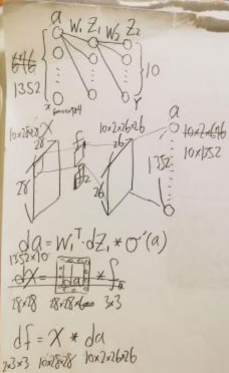

In [14]:
class CNN_Onelayer:
    def __init__(self, num_class, num_filter, num_FC_neuron, epochs, batch_size, learning_rate, kernel_size=(3, 3), stride=1):
        self.num_class = num_class
        self.num_filter = num_filter
        self.num_FC_neuron = num_FC_neuron
        self.batch_size = batch_size
        self.batch_counts = int(len(train_X) / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.stride = stride
        self.filter = np.random.randn(self.num_filter, self.kernel_size[0], self.kernel_size[1])  # (2, 3, 3)
        np.random.seed(1)
        self.w1 = np.random.randn(num_FC_neuron, num_filter * ((len(train_X[0]) - self.kernel_size[0] + 1)**2))
        np.random.seed(2)
        self.b1 = np.random.randn(num_FC_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_FC_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)

    def CNN_forward(self, input):
        input_num = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        feature_map = np.zeros((input_num, self.num_filter, input_num_row - self.kernel_size[0] + 1, input_num_column - self.kernel_size[1] + 1))
        # print(feature_map.shape)  # (10, 2, 26, 26)
        self.feature_map_size = len(feature_map[0,0])

        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(feature_map[0])):
                    for RL_move in range(len(feature_map[0, 0])):
                        matrix = input[i, UD_move:(UD_move+self.kernel_size[0]), RL_move:(RL_move+self.kernel_size[1])]  # 當下要乘的輸入矩陣
                        feature_map[i, filter, UD_move, RL_move] = relu(np.sum(self.filter[filter] * matrix))  # no bias

        return feature_map

    def Pooling(self, input, pooling_size=(2, 2)):
        input_num_channel = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        feature_map_pooled_num_row = int(input_num_row / pooling_size_num_row)
        feature_map_pooled_num_column = int(input_num_column / pooling_size_num_column)
        print(feature_map_pooled_num_row)
        print(feature_map_pooled_num_column)
        self.feature_map_pooled = np.zeros((input_num_channel, feature_map_pooled_num_row, feature_map_pooled_num_column))

        for channel in range(input_num_channel):
            for column in range(feature_map_pooled_num_column):
                for row in range(feature_map_pooled_num_row):
                    # 當下的比較範圍取最大值
                    matrix = input[channel, (row*pooling_size_num_row):(row*pooling_size_num_row+pooling_size_num_row),
                                   (column*pooling_size_num_column):(column*pooling_size_num_column+pooling_size_num_column)]
                    self.feature_map_pooled[channel, row, column] = np.max(matrix)

        return self.feature_map_pooled

    def Flatten(self, input):
        input_num = len(input)
        channel = len(input[0])
        output = input.reshape(input_num, channel, (len(input[0, 0]) * len(input[0, 0, 0])))  # (10, 2, 676)
        a = len(output[0]) * len(output[0, 0])
        return output.reshape(input_num, a).T

    def FC_forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def save_loss_accuracy(self, predict, ground_truth, start, end):  # 計算損失和準確率
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):  # 儲存損失和準確率，做畫圖用
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 3)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)
        print("Epoch {}, accuracy = {} %".format(index+1, self.Accuracy_for_Plot[index]))

    def FC_backward(self, predict, ground_truth, matrix_flatten):  # 全連接神經網路的後向傳播
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size
        # da為CNN輸出後(flatten後)的梯度
        self.da = np.dot(self.w1.T, self.dz1) * relu_derive(matrix_flatten)
        # print(self.da.shape)  # (1352, 10)

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def Pooling_backward(self, input):  # 池化層(pooling)的後向傳播(未完成)

        return 1

    def CNN_backward(self, train_input):  # CNN的後向傳播
        # filter參數的梯度
        df = np.zeros((self.num_filter, self.kernel_size[0], self.kernel_size[1]))
        self.da = self.da.T  # (10, 1352)
        self.da = self.da.reshape(self.batch_size, self.num_filter, self.feature_map_size ** 2)  # (10, 2, 676)
        self.da = self.da.reshape(self.batch_size, self.num_filter, self.feature_map_size, self.feature_map_size)  # (10, 2, 26, 26)
        input_num = len(train_input)

        # 根據公式，把da當作filter對training input做掃描後，得到filter參數的梯度
        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(df[0])):
                    for RL_move in range(len(df[0, 0])):
                        matrix = train_input[i, UD_move:(UD_move+len(self.da[0, 0])), RL_move:(RL_move+len(self.da[0, 0, 0]))]  # 當下要乘的輸入矩陣
                        df[filter, UD_move, RL_move] += np.sum(self.da[i, filter] * matrix)

        df = df / input_num

        # update filter parameters
        self.filter = self.filter - self.learning_rate * df

    def show_accuracy_loss(self, showtext=False):  # 畫出準確率和損失圖
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                # 決定當前epoch的範圍
                start = batch_count * self.batch_size
                end = start + self.batch_size

                self.CNN_output = self.Flatten(self.CNN_forward(train_X[start:end]))
                self.FC_output = self.FC_forward(self.CNN_output)
                self.FC_backward(self.FC_output, y_train_one_hot[:, start:end], self.CNN_output)
                self.CNN_backward(train_X[start:end])
                self.save_loss_accuracy(self.FC_output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        CNN_output = self.Flatten(self.CNN_forward(input))
        self.predict_result = self.FC_forward(CNN_output)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(y_predict_test)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(y_predict_test) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

In [15]:
nn1 = CNN_Onelayer(10, 2, 30, 10, 10, 0.1)
nn1.train()
nn1.predict_test(test_X)

Epoch 1, accuracy = 12.4 %
Epoch 2, accuracy = 16.8 %
Epoch 3, accuracy = 18.3 %
Epoch 4, accuracy = 19.3 %


KeyboardInterrupt: ignored

# **CNN case.2**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
***CNN number of filter:*** `5`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `4 min 49 sec`<p>

Epoch 1, accuracy = 24.8 %
Epoch 2, accuracy = 37.0 %
Epoch 3, accuracy = 43.1 %
Epoch 4, accuracy = 47.4 %
Epoch 5, accuracy = 49.4 %
Epoch 6, accuracy = 51.6 %
Epoch 7, accuracy = 52.9 %
Epoch 8, accuracy = 53.3 %
Epoch 9, accuracy = 54.1 %
Epoch 10, accuracy = 55.0 %


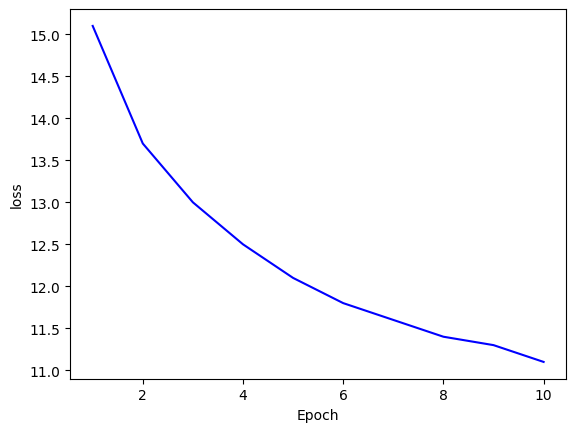

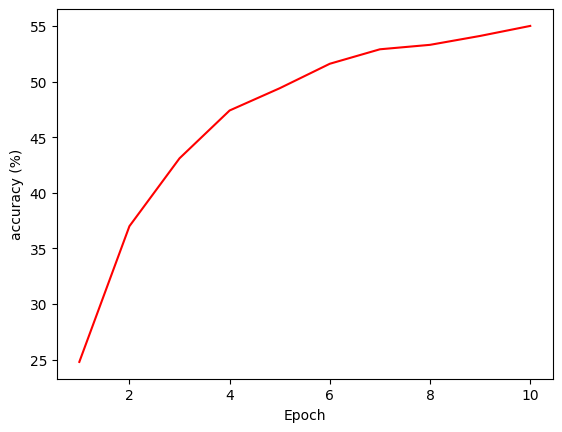

Test set accuracy:48.17%


In [ ]:
nn2 = CNN_Onelayer(10, 5, 30, 10, 10, 0.1)
nn2.train()
nn2.predict_test(test_X)

# **CNN case.3**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
***CNN number of filter:*** `10`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `14 min 13 sec`<p>

Epoch 1, accuracy = 27.1 %
Epoch 2, accuracy = 44.3 %
Epoch 3, accuracy = 49.1 %
Epoch 4, accuracy = 52.7 %
Epoch 5, accuracy = 56.8 %
Epoch 6, accuracy = 60.7 %
Epoch 7, accuracy = 60.6 %
Epoch 8, accuracy = 63.7 %
Epoch 9, accuracy = 63.1 %
Epoch 10, accuracy = 65.4 %


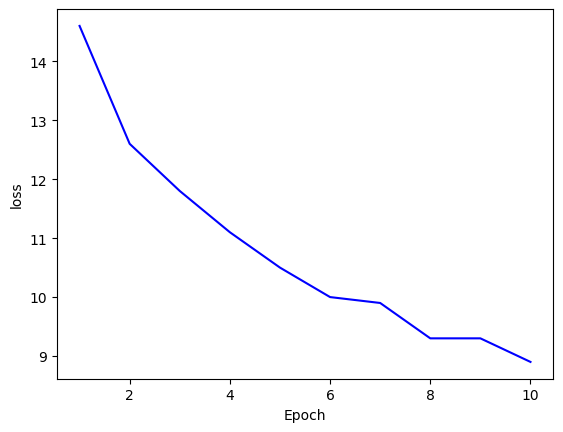

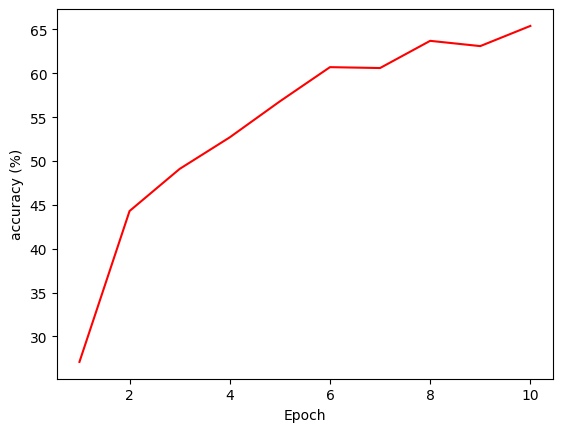

Test set accuracy:58.87%


In [ ]:
nn3 = CNN_Onelayer(10, 10, 30, 10, 10, 0.1)
nn3.train()
nn3.predict_test(test_X)

# **CNN case.4**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `5`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
***Batch size:*** `30`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `3 min 48 sec`<p>

Epoch 1, accuracy = 20.6 %
Epoch 2, accuracy = 28.7 %
Epoch 3, accuracy = 35.8 %
Epoch 4, accuracy = 38.7 %
Epoch 5, accuracy = 41.6 %
Epoch 6, accuracy = 42.8 %
Epoch 7, accuracy = 43.7 %
Epoch 8, accuracy = 44.0 %
Epoch 9, accuracy = 45.6 %
Epoch 10, accuracy = 46.8 %


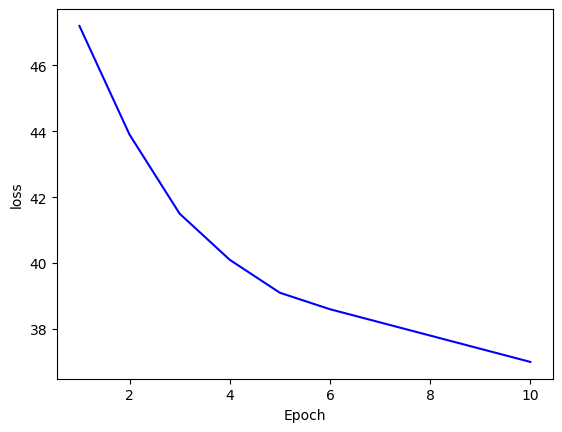

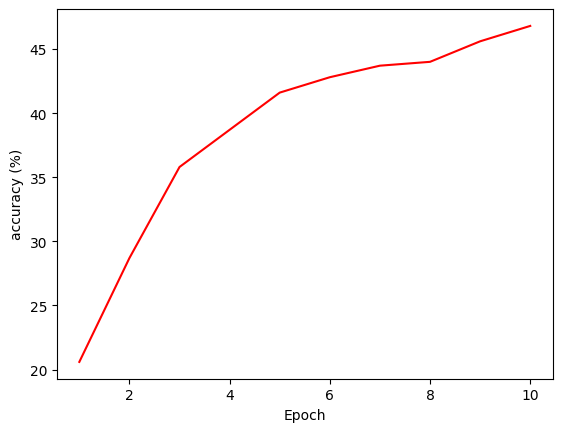

Test set accuracy:40.17%


In [ ]:
nn4 = CNN_Onelayer(10, 5, 30, 10, 30, 0.1)
nn4.train()
nn4.predict_test(test_X)

# **CNN case.5**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
***Fully-connected NN Activation function:*** `ReLU`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `2`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `1 min 21 sec`<p>

In [ ]:
class CNN_Onelayer_FC_ReLU:
    def __init__(self, num_class, num_filter, num_FC_neuron, epochs, batch_size, learning_rate, kernel_size=(3, 3), stride=1):
        self.num_class = num_class
        self.num_filter = num_filter
        self.num_FC_neuron = num_FC_neuron
        self.batch_size = batch_size
        self.batch_counts = int(len(train_X) / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.stride = stride
        self.filter = np.random.randn(self.num_filter, self.kernel_size[0], self.kernel_size[1])  # (2, 3, 3)
        np.random.seed(1)
        self.w1 = np.random.randn(num_FC_neuron, num_filter * (26**2))
        np.random.seed(2)
        self.b1 = np.random.randn(num_FC_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_FC_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)

    def CNN_forward(self, input):
        input_num = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        feature_map = np.zeros((input_num, self.num_filter, input_num_row - self.kernel_size[0] + 1, input_num_column - self.kernel_size[1] + 1))
        # print(feature_map.shape)  # (10, 2, 26, 26)

        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(feature_map[0])):
                    for RL_move in range(len(feature_map[0, 0])):
                        matrix = input[i, UD_move:(UD_move+self.kernel_size[0]), RL_move:(RL_move+self.kernel_size[1])]  # 當下要乘的輸入矩陣
                        feature_map[i, filter, UD_move, RL_move] = relu(np.sum(self.filter[filter] * matrix))  # no bias

        return feature_map

    def Pooling(self, input, pooling_size=(2, 2)):
        input_num_channel = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        feature_map_pooled_num_row = int(input_num_row / pooling_size_num_row)
        feature_map_pooled_num_column = int(input_num_column / pooling_size_num_column)
        print(feature_map_pooled_num_row)
        print(feature_map_pooled_num_column)
        self.feature_map_pooled = np.zeros((input_num_channel, feature_map_pooled_num_row, feature_map_pooled_num_column))

        for channel in range(input_num_channel):
            for column in range(feature_map_pooled_num_column):
                for row in range(feature_map_pooled_num_row):
                    # 當下的比較範圍取最大值
                    matrix = input[channel, (row*pooling_size_num_row):(row*pooling_size_num_row+pooling_size_num_row),
                                   (column*pooling_size_num_column):(column*pooling_size_num_column+pooling_size_num_column)]
                    self.feature_map_pooled[channel, row, column] = np.max(matrix)

        return self.feature_map_pooled

    def Flatten(self, input):
        input_num = len(input)
        channel = len(input[0])
        output = input.reshape(input_num, channel, (len(input[0, 0]) * len(input[0, 0, 0])))  # (10, 2, 676)
        a = len(output[0]) * len(output[0, 0])
        return output.reshape(input_num, a).T

    def FC_forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = relu(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def save_loss_accuracy(self, predict, ground_truth, start, end):  # 計算損失和準確率
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):  # 儲存損失和準確率，做畫圖用
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)
        print("Epoch {}, accuracy = {} %".format(index+1, self.Accuracy_for_Plot[index]))

    def FC_backward(self, predict, ground_truth, matrix_flatten):  # 全連接神經網路的後向傳播
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * relu_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size
        # da為CNN輸出後(flatten後)的梯度
        self.da = np.dot(self.w1.T, self.dz1) * relu_derive(matrix_flatten)
        # print(self.da.shape)  # (1352, 10)

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def Pooling_backward(self):  # 池化層(pooling)的後向傳播(未完成)
        return 1

    def CNN_backward(self, train_input):  # CNN的後向傳播
        # filter參數的梯度
        df = np.zeros((self.num_filter, self.kernel_size[0], self.kernel_size[1]))
        self.da = self.da.T  # (10, 1352)
        self.da = self.da.reshape(self.batch_size, self.num_filter, 676)  # (10, 2, 676)
        self.da = self.da.reshape(self.batch_size, self.num_filter, 26, 26)  # (10, 2, 26, 26)
        input_num = len(train_input)

        # 根據公式，把da當作filter對training input做掃描後，得到filter參數的梯度
        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(df[0])):
                    for RL_move in range(len(df[0, 0])):
                        matrix = train_input[i, UD_move:(UD_move+len(self.da[0, 0])), RL_move:(RL_move+len(self.da[0, 0, 0]))]  # 當下要乘的輸入矩陣
                        df[filter, UD_move, RL_move] = np.sum(self.da[i, filter] * matrix)

        # update filter parameters
        self.filter = self.filter - self.learning_rate * df

    def show_accuracy_loss(self, showtext=False):  # 畫出準確率和損失圖
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                # 決定當前epoch的範圍
                start = batch_count * self.batch_size
                end = start + self.batch_size

                self.CNN_output = self.Flatten(self.CNN_forward(train_X[start:end]))
                self.FC_output = self.FC_forward(self.CNN_output)
                self.FC_backward(self.FC_output, y_train_one_hot[:, start:end], self.CNN_output)
                self.CNN_backward(train_X[start:end])
                self.save_loss_accuracy(self.FC_output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        CNN_output = self.Flatten(self.CNN_forward(input))
        self.predict_result = self.FC_forward(CNN_output)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(y_predict_test)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(y_predict_test) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

Epoch 1, accuracy = 12.1 %
Epoch 2, accuracy = 12.2 %
Epoch 3, accuracy = 16.7 %
Epoch 4, accuracy = 16.3 %
Epoch 5, accuracy = 17.3 %
Epoch 6, accuracy = 19.1 %
Epoch 7, accuracy = 19.8 %
Epoch 8, accuracy = 20.5 %
Epoch 9, accuracy = 20.4 %
Epoch 10, accuracy = 20.5 %


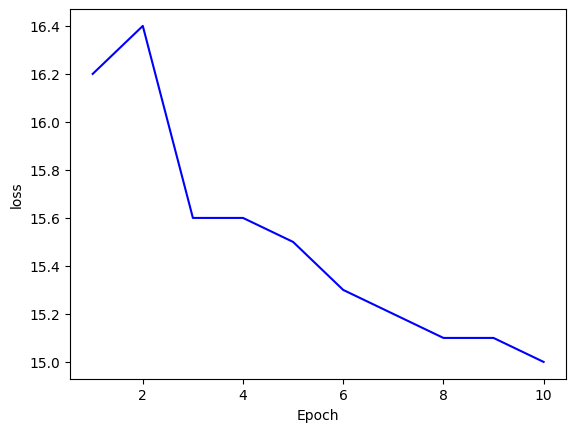

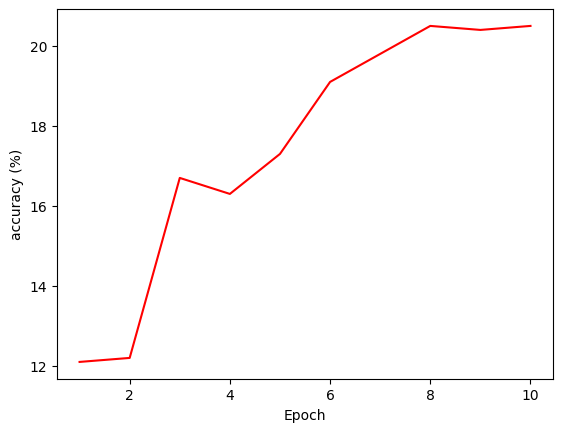

Test set accuracy:18.97%


In [ ]:
nn5 = CNN_Onelayer_FC_ReLU(10, 2, 30, 10, 10, 0.1)
nn5.train()
nn5.predict_test(test_X)

# **CNN case.6**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `ReLU`<p>
*CNN Activation function:* `ReLU`<p>
***CNN number of filter:*** `5`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `7 min 2 sec`<p>

Epoch 1, accuracy = 12.2 %
Epoch 2, accuracy = 9.7 %
Epoch 3, accuracy = 9.8 %
Epoch 4, accuracy = 9.8 %
Epoch 5, accuracy = 9.6 %
Epoch 6, accuracy = 9.8 %
Epoch 7, accuracy = 9.9 %
Epoch 8, accuracy = 9.9 %
Epoch 9, accuracy = 9.9 %
Epoch 10, accuracy = 10.1 %


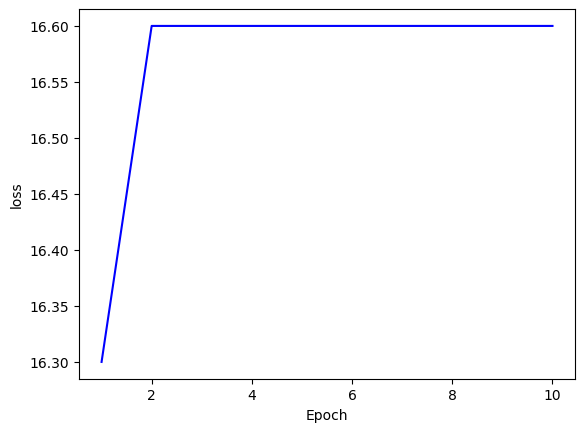

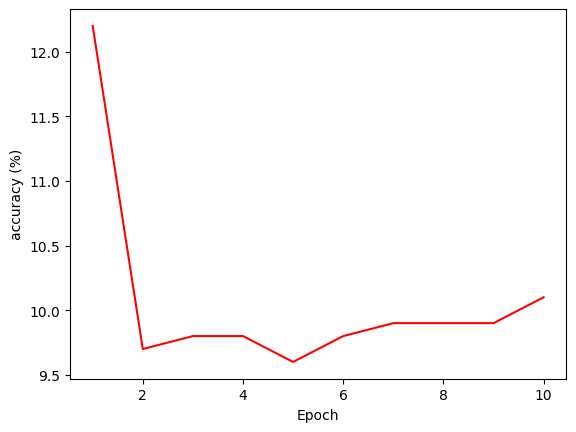

Test set accuracy:11.27%


In [ ]:
nn6 = CNN_Onelayer_FC_ReLU(10, 5, 30, 10, 10, 0.1)
nn6.train()
nn6.predict_test(test_X)

# **CNN case.7**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
***CNN number of filter:*** `20`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `1 hr 7 min 56 sec`<p>

Epoch 1, accuracy = 26.5 %
Epoch 2, accuracy = 52.0 %
Epoch 3, accuracy = 59.6 %
Epoch 4, accuracy = 63.7 %
Epoch 5, accuracy = 67.1 %
Epoch 6, accuracy = 66.2 %
Epoch 7, accuracy = 66.0 %
Epoch 8, accuracy = 69.6 %
Epoch 9, accuracy = 72.3 %
Epoch 10, accuracy = 73.8 %


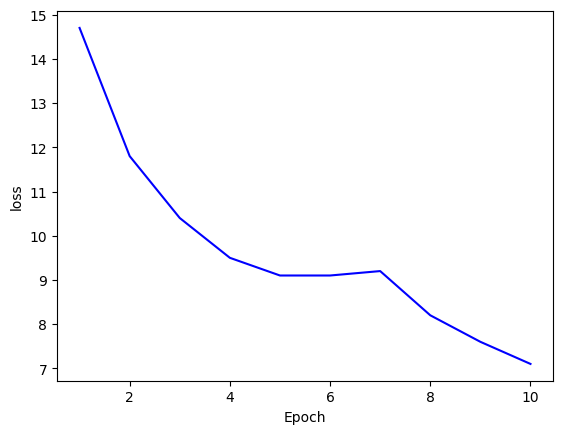

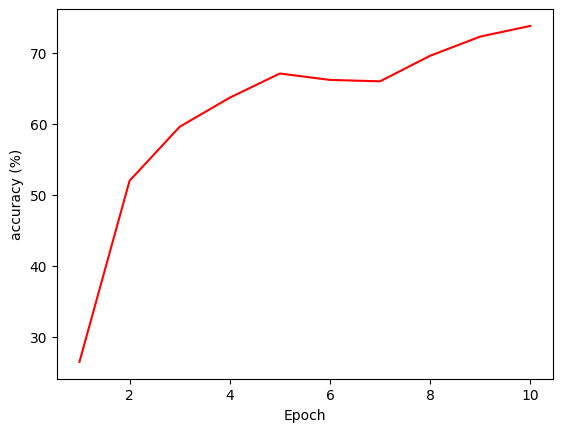

Test set accuracy:66.7%


In [ ]:
nn7 = CNN_Onelayer(10, 20, 30, 10, 10, 0.1)
nn7.train()
nn7.predict_test(test_X)

# **CNN case.8**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `5`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `no`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `4 min 41 sec`<p>
***FC_backward function average removed***<p>

In [ ]:
class CNN_Onelayer_v1:
    def __init__(self, num_class, num_filter, num_FC_neuron, epochs, batch_size, learning_rate, kernel_size=(3, 3), stride=1):
        self.num_class = num_class
        self.num_filter = num_filter
        self.num_FC_neuron = num_FC_neuron
        self.batch_size = batch_size
        self.batch_counts = int(len(train_X) / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.stride = stride
        self.filter = np.random.randn(self.num_filter, self.kernel_size[0], self.kernel_size[1])  # (2, 3, 3)
        np.random.seed(1)
        self.w1 = np.random.randn(num_FC_neuron, num_filter * ((len(train_X[0]) - self.kernel_size[0] + 1)**2))
        np.random.seed(2)
        self.b1 = np.random.randn(num_FC_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_FC_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.feature_map_no_activation_flatten = np.zeros((batch_size, num_filter, (26**2)))
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)

    def CNN_forward(self, input):
        input_num = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        feature_map = np.zeros((input_num, self.num_filter, input_num_row - self.kernel_size[0] + 1, input_num_column - self.kernel_size[1] + 1))
        # print(feature_map.shape)  # (10, 2, 26, 26)

        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(feature_map[0])):
                    for RL_move in range(len(feature_map[0, 0])):
                        matrix = input[i, UD_move:(UD_move+self.kernel_size[0]), RL_move:(RL_move+self.kernel_size[1])]  # 當下要乘的輸入矩陣
                        feature_map[i, filter, UD_move, RL_move] = np.sum(self.filter[filter] * matrix)  # no bias

        self.feature_map_no_activation_flatten = feature_map.reshape(input_num, self.num_filter, len(feature_map[0,0]) * len(feature_map[0,0,0]))  # (10, 2, 676)
        self.feature_map_no_activation_flatten = self.feature_map_no_activation_flatten.reshape(input_num, self.num_filter * len(feature_map[0,0]) * len(feature_map[0,0,0])).T  # (1352, 10)
        feature_map = relu(feature_map)
        return feature_map

    def Pooling(self, input, pooling_size=(2, 2)):
        input_num_channel = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        feature_map_pooled_num_row = int(input_num_row / pooling_size_num_row)
        feature_map_pooled_num_column = int(input_num_column / pooling_size_num_column)
        print(feature_map_pooled_num_row)
        print(feature_map_pooled_num_column)
        self.feature_map_pooled = np.zeros((input_num_channel, feature_map_pooled_num_row, feature_map_pooled_num_column))

        for channel in range(input_num_channel):
            for column in range(feature_map_pooled_num_column):
                for row in range(feature_map_pooled_num_row):
                    # 當下的比較範圍取最大值
                    matrix = input[channel, (row*pooling_size_num_row):(row*pooling_size_num_row+pooling_size_num_row),
                                   (column*pooling_size_num_column):(column*pooling_size_num_column+pooling_size_num_column)]
                    self.feature_map_pooled[channel, row, column] = np.max(matrix)

        return self.feature_map_pooled

    def Flatten(self, input):
        input_num = len(input)
        channel = len(input[0])
        output = input.reshape(input_num, channel, (len(input[0, 0]) * len(input[0, 0, 0])))  # (10, 2, 676)
        a = len(output[0]) * len(output[0, 0])
        return output.reshape(input_num, a).T

    def FC_forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def save_loss_accuracy(self, predict, ground_truth, start, end):  # 計算損失和準確率
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):  # 儲存損失和準確率，做畫圖用
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 3)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)
        print("Epoch {}, accuracy = {} %".format(index+1, self.Accuracy_for_Plot[index]))

    def FC_backward(self, predict, ground_truth, matrix_flatten):  # 全連接神經網路的後向傳播
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T)
        self.db2 = np.sum(dz2, axis=1, keepdims=True)
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T)
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True)
        # da為CNN輸出後(flatten後)的梯度
        self.da = np.dot(self.w1.T, self.dz1) * relu_derive(matrix_flatten)
        # print(self.da.shape)  # (1352, 10)

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def Pooling_backward(self, input):  # 池化層(pooling)的後向傳播(未完成)

        return 1

    def CNN_backward(self, train_input):  # CNN的後向傳播
        # filter參數的梯度
        df = np.zeros((self.num_filter, self.kernel_size[0], self.kernel_size[1]))
        self.da = self.da.T  # (10, 1352)
        self.da = self.da.reshape(self.batch_size, self.num_filter, 676)  # (10, 2, 676)
        self.da = self.da.reshape(self.batch_size, self.num_filter, 26, 26)  # (10, 2, 26, 26)
        input_num = len(train_input)

        # 根據公式，把da當作filter對training input做掃描後，得到filter參數的梯度
        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(df[0])):
                    for RL_move in range(len(df[0, 0])):
                        matrix = train_input[i, UD_move:(UD_move+len(self.da[0, 0])), RL_move:(RL_move+len(self.da[0, 0, 0]))]  # 當下要乘的輸入矩陣
                        df[filter, UD_move, RL_move] = np.sum(self.da[i, filter] * matrix)

        # update filter parameters
        self.filter = self.filter - self.learning_rate * df

    def show_accuracy_loss(self, showtext=False):  # 畫出準確率和損失圖
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                # 決定當前epoch的範圍
                start = batch_count * self.batch_size
                end = start + self.batch_size

                self.CNN_output = self.Flatten(self.CNN_forward(train_X[start:end]))
                self.FC_output = self.FC_forward(self.CNN_output)
                self.FC_backward(self.FC_output, y_train_one_hot[:, start:end], self.feature_map_no_activation_flatten)
                self.CNN_backward(train_X[start:end])
                self.save_loss_accuracy(self.FC_output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        CNN_output = self.Flatten(self.CNN_forward(input))
        self.predict_result = self.FC_forward(CNN_output)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(y_predict_test)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(y_predict_test) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

In [ ]:
nn8 = CNN_Onelayer_v1(10, 5, 30, 10, 10, 0.1)
nn8.train()
nn8.predict_test(test_X)

Epoch 1, accuracy = 37.0 %
Epoch 2, accuracy = 46.6 %
Epoch 3, accuracy = 50.4 %


KeyboardInterrupt: ignored

# **CNN case.9**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `5`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
***CNN Pooling:*** `2x2`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `10 min 28 sec`<p>

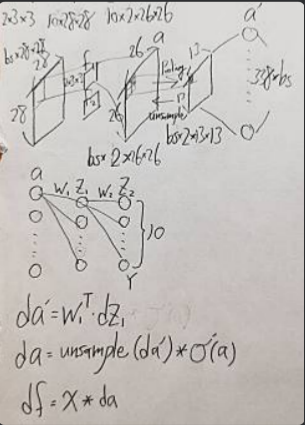

In [ ]:
class CNN_Onelayer_Pooling:
    def __init__(self, num_class, num_filter, num_FC_neuron, epochs, batch_size, learning_rate, kernel_size=(3, 3), stride=1):
        self.num_class = num_class
        self.num_filter = num_filter
        self.num_FC_neuron = num_FC_neuron
        self.batch_size = batch_size
        self.batch_counts = int(len(train_X) / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.stride = stride
        self.filter = np.random.randn(self.num_filter, self.kernel_size[0], self.kernel_size[1]) * 0.2 - 0.1  # (2, 3, 3)
        np.random.seed(1)
        self.w1 = np.random.randn(num_FC_neuron, num_filter * (int((len(train_X[0]) - self.kernel_size[0] + 1)/2)**2)) * 0.2 - 0.1
        np.random.seed(2)
        self.b1 = np.random.randn(num_FC_neuron, 1) * 0.000002 - 0.000001
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_FC_neuron) * 0.2 - 0.1
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1) * 0.000002 - 0.000001
        self.feature_map_no_activation_flatten = np.zeros((batch_size, num_filter, (26**2)))
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)

    def CNN_forward(self, input):
        input_num = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        feature_map = np.zeros((input_num, self.num_filter, input_num_row - self.kernel_size[0] + 1, input_num_column - self.kernel_size[1] + 1))
        # print(feature_map.shape)  # (10, 2, 26, 26)
        self.feature_map_size = len(feature_map[0,0])

        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(feature_map[0])):
                    for RL_move in range(len(feature_map[0, 0])):
                        matrix = input[i, UD_move:(UD_move+self.kernel_size[0]), RL_move:(RL_move+self.kernel_size[1])]  # 當下要乘的輸入矩陣
                        feature_map[i, filter, UD_move, RL_move] = np.sum(self.filter[filter] * matrix)  # no bias

        self.feature_map_no_activation_flatten = feature_map.reshape(input_num, self.num_filter, len(feature_map[0,0]) * len(feature_map[0,0,0]))  # (10, 2, 676)
        self.feature_map_no_activation_flatten = self.feature_map_no_activation_flatten.reshape(input_num, self.num_filter * len(feature_map[0,0]) * len(feature_map[0,0,0])).T  # (1352, 10)
        feature_map_relu = relu(feature_map)
        return feature_map_relu, feature_map

    def Pooling(self, input, pooling_size=(2, 2)):
        input_num = len(input)
        input_num_filter = len(input[0])
        input_num_row = len(input[0, 0])
        input_num_column = len(input[0, 0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        self.feature_map_pooling_size = int(self.feature_map_size / pooling_size[0])
        feature_map_pooled_num_row = int(input_num_row / pooling_size_num_row)
        feature_map_pooled_num_column = int(input_num_column / pooling_size_num_column)
        # print(feature_map_pooled_num_row)
        # print(feature_map_pooled_num_column)
        self.feature_map_pooled = np.zeros((input_num, input_num_filter, feature_map_pooled_num_row, feature_map_pooled_num_column))
        self.feature_map_pooling_position = np.zeros((input_num, input_num_filter, feature_map_pooled_num_row, feature_map_pooled_num_column))

        for i in range(input_num):
            for filter_num in range(input_num_filter):
                for column in range(feature_map_pooled_num_column):
                    for row in range(feature_map_pooled_num_row):
                        # 當下的比較範圍取最大值
                        matrix = input[i, filter_num, (row*pooling_size_num_row):(row*pooling_size_num_row+pooling_size_num_row),
                                      (column*pooling_size_num_column):(column*pooling_size_num_column+pooling_size_num_column)]
                        self.feature_map_pooled[i, filter_num, row, column] = np.max(matrix)
                        self.feature_map_pooling_position[i, filter_num, row, column] = np.argmax(matrix)

        return self.feature_map_pooled

    def Flatten(self, input):
        input_num = len(input)
        channel = len(input[0])
        output = input.reshape(input_num, channel, (len(input[0, 0]) * len(input[0, 0, 0])))  # (10, 2, 676)
        a = len(output[0]) * len(output[0, 0])
        return output.reshape(input_num, a).T

    def FC_forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def save_loss_accuracy(self, predict, ground_truth, start, end):  # 計算損失和準確率
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):  # 儲存損失和準確率，做畫圖用
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 3)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)
        print("Epoch {}, accuracy = {} %".format(index+1, self.Accuracy_for_Plot[index]))

    def FC_backward(self, predict, ground_truth, ):  # 全連接神經網路的後向傳播
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T)
        self.db2 = np.sum(dz2, axis=1, keepdims=True)
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T)
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True)
        # da為CNN輸出後(flatten後)的梯度
        self.da_pulum = np.dot(self.w1.T, self.dz1)
        # print(self.da.shape)  # (338, 10)

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def Pooling_backward(self, feature_map, pooling_size=(2, 2)):  # 池化層(pooling)的後向傳播
        self.da_pulum = self.da_pulum.T  # (10, 338)
        self.da_pulum = self.da_pulum.reshape(self.batch_size, self.num_filter, self.feature_map_pooling_size ** 2)  # (10, 2, 169)
        self.da_pulum = self.da_pulum.reshape(self.batch_size, self.num_filter, self.feature_map_pooling_size, self.feature_map_pooling_size)  # (10, 2, 13, 13)
        input_num = len(self.da_pulum)
        input_filter_num = len(self.da_pulum[0])
        input_num_row = len(self.da_pulum[0, 0])
        input_num_column = len(self.da_pulum[0, 0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        unsample_result = np.zeros((input_num, input_filter_num, (len(train_X[0]) - self.kernel_size[0] + 1), (len(train_X[0, 0]) - self.kernel_size[1] + 1)))

        def update_matrix(matrix, max_index, max_value):  # 藉由最大值的位置與值來更新
            matrix[max_index // matrix.shape[1], max_index % matrix.shape[1]] = max_value

        for i in range(input_num):
            for filter_num in range(self.num_filter):
                for column in range(input_num_column):
                    for row in range(input_num_row):
                        matrix = unsample_result[i, filter_num, (row * pooling_size_num_row):(row * pooling_size_num_row + pooling_size_num_row),
                                                 (column * pooling_size_num_column):(column * pooling_size_num_column + pooling_size_num_column)]
                        update_matrix(matrix, int(self.feature_map_pooling_position[i, filter_num, row, column]), self.da_pulum[i, filter_num, row, column])

        self.da = unsample_result * relu_derive(feature_map)

    def CNN_backward(self, train_input):  # CNN的後向傳播
        # filter參數的梯度
        df = np.zeros((self.num_filter, self.kernel_size[0], self.kernel_size[1]))
        input_num = len(train_input)

        # 根據公式，把da當作filter對training input做掃描後，得到filter參數的梯度
        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(df[0])):
                    for RL_move in range(len(df[0, 0])):
                        matrix = train_input[i, UD_move:(UD_move+len(self.da[0, 0])), RL_move:(RL_move+len(self.da[0, 0, 0]))]  # 當下要乘的輸入矩陣
                        df[filter, UD_move, RL_move] += np.sum(self.da[i, filter] * matrix)

        df = df / input_num

        # update filter parameters
        self.filter = self.filter - self.learning_rate * df

    def show_accuracy_loss(self, showtext=False):  # 畫出準確率和損失圖
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                # 決定當前epoch的範圍
                start = batch_count * self.batch_size
                end = start + self.batch_size

                feature_map_relu, feature_map = self.CNN_forward(train_X[start:end])
                CNN_output = self.Flatten(self.Pooling(feature_map_relu))
                FC_output = self.FC_forward(CNN_output)
                self.FC_backward(FC_output, y_train_one_hot[:, start:end])
                self.Pooling_backward(feature_map)
                self.CNN_backward(train_X[start:end])
                self.save_loss_accuracy(FC_output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        CNN_output = self.Flatten(self.Pooling(self.CNN_forward(input)))
        self.predict_result = self.FC_forward(CNN_output)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(y_predict_test)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(y_predict_test) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

    def check_gradient(self, input, ground_truth, small_delta=1e-4):
        # original
        CNN_output = self.Flatten(self.Pooling(self.CNN_forward(input)))
        original_result = self.FC_forward(CNN_output)

        # after small_delta
        self.w2 = self.w2 - small_delta
        CNN_output_small_delta = self.Flatten(self.Pooling(self.CNN_forward(input)))
        self.z1 = np.dot(self.w1, CNN_output_small_delta) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        result_small_delta = softmax(self.z2)
        dz2 = result_small_delta - original_result
        self.dw2 = np.dot(dz2, self.A1.T)
        print("比值(small_delta / self.dw2):", np.mean(small_delta / self.dw2))

Epoch 1, accuracy = 39.9 %
Epoch 2, accuracy = 52.1 %
Epoch 3, accuracy = 53.7 %
Epoch 4, accuracy = 55.0 %
Epoch 5, accuracy = 55.7 %
Epoch 6, accuracy = 56.2 %
Epoch 7, accuracy = 57.2 %
Epoch 8, accuracy = 57.5 %
Epoch 9, accuracy = 58.0 %
Epoch 10, accuracy = 58.3 %


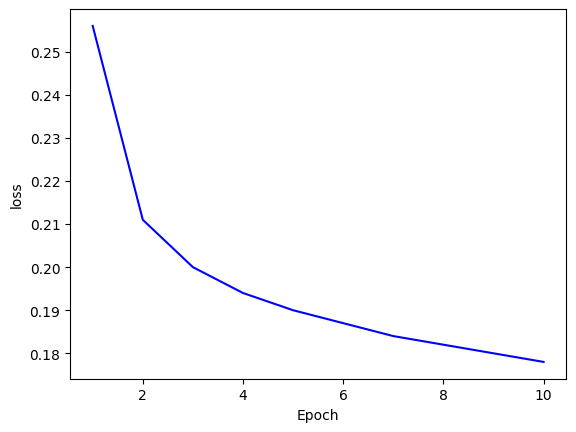

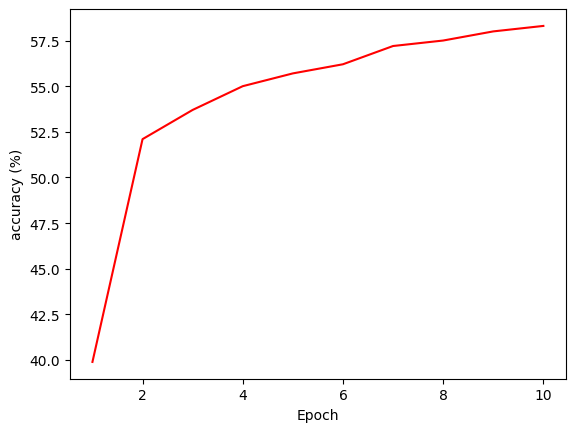

TypeError: ignored

In [ ]:
nn9 = CNN_Onelayer_Pooling(10, 5, 30, 10, 10, 0.1)
nn9.train()
nn9.predict_test(test_X)

# **CNN case.10**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `5`<p>
***CNN size of filter:*** `5x5`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `2x2`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `9 min 45 sec`<p>

Epoch 1, accuracy = 25.6 %
Epoch 2, accuracy = 44.7 %
Epoch 3, accuracy = 50.9 %
Epoch 4, accuracy = 55.3 %
Epoch 5, accuracy = 57.1 %
Epoch 6, accuracy = 58.4 %
Epoch 7, accuracy = 59.4 %
Epoch 8, accuracy = 61.6 %
Epoch 9, accuracy = 62.4 %
Epoch 10, accuracy = 62.9 %


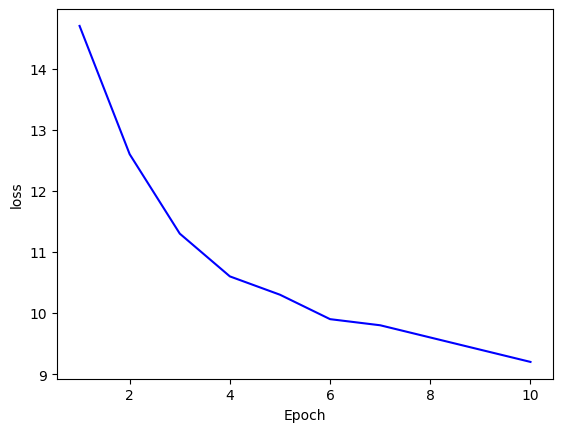

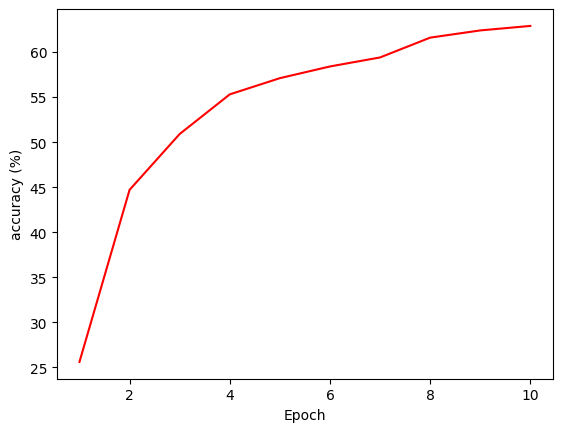

Test set accuracy:56.43%


In [ ]:
nn10 = CNN_Onelayer_Pooling(10, 5, 30, 10, 10, 0.1, (5, 5))
nn10.train()
nn10.predict_test(test_X)

# **CNN case.11**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
***CNN number of filter:*** `10`<p>
*CNN size of filter:* `5x5`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `2x2`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `29 min 33 sec`<p>

Epoch 1, accuracy = 27.5 %
Epoch 2, accuracy = 45.3 %
Epoch 3, accuracy = 53.0 %
Epoch 4, accuracy = 61.5 %
Epoch 5, accuracy = 64.8 %
Epoch 6, accuracy = 67.0 %
Epoch 7, accuracy = 67.0 %
Epoch 8, accuracy = 70.8 %
Epoch 9, accuracy = 72.2 %
Epoch 10, accuracy = 72.0 %


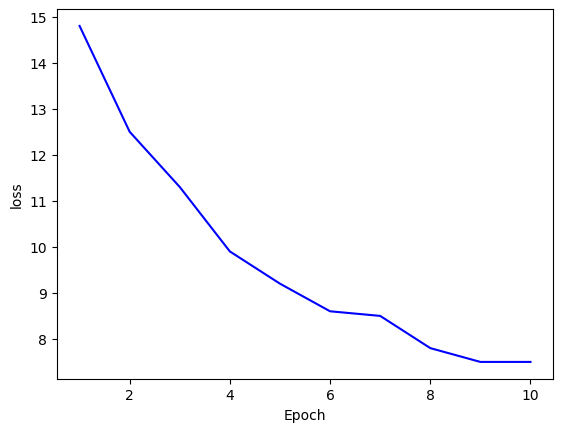

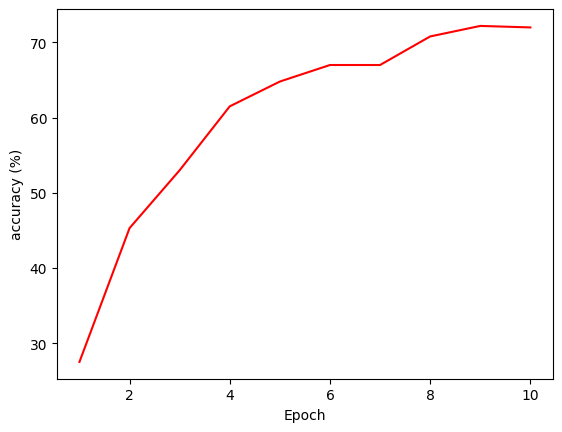

Test set accuracy:68.3%


In [ ]:
nn11 = CNN_Onelayer_Pooling(10, 10, 30, 10, 10, 0.1, (5, 5))
nn11.train()
nn11.predict_test(test_X)

# **CNN case.12**
*The number of neurons in Fully-connected NN hidden layer:* `30`<p>
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `5`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
***CNN bias:*** `Yes`<p>
*CNN Pooling:* `2x2`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* `10 min 28 sec`<p>

In [ ]:
class CNN_Onelayer_Pooling_bias:
    def __init__(self, num_class, num_filter, num_FC_neuron, epochs, batch_size, learning_rate, kernel_size=(3, 3), stride=1):
        self.num_class = num_class
        self.num_filter = num_filter
        self.num_FC_neuron = num_FC_neuron
        self.batch_size = batch_size
        self.batch_counts = int(len(train_X) / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.stride = stride
        self.filter = np.random.randn(self.num_filter, self.kernel_size[0], self.kernel_size[1])  # (2, 3, 3)
        self.cnn_bias = np.random.randn(num_filter, 28 - self.kernel_size[0] + 1, 28 - self.kernel_size[1] + 1)
        np.random.seed(1)
        self.w1 = np.random.randn(num_FC_neuron, num_filter * (int((len(train_X[0]) - self.kernel_size[0] + 1)/2)**2))
        np.random.seed(2)
        self.b1 = np.random.randn(num_FC_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_FC_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)

    def CNN_forward(self, input):
        input_num = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        feature_map = np.zeros((input_num, self.num_filter, input_num_row - self.kernel_size[0] + 1, input_num_column - self.kernel_size[1] + 1))
        # print(feature_map.shape)  # (10, 2, 26, 26)
        self.feature_map_size = len(feature_map[0,0])

        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(feature_map[0])):
                    for RL_move in range(len(feature_map[0, 0])):
                        matrix = input[i, UD_move:(UD_move+self.kernel_size[0]), RL_move:(RL_move+self.kernel_size[1])]  # 當下要乘的輸入矩陣
                        feature_map[i, filter, UD_move, RL_move] = relu(np.sum(self.filter[filter] * matrix) + self.cnn_bias[filter, UD_move, RL_move])

        return feature_map

    def Pooling(self, input, pooling_size=(2, 2)):
        input_num = len(input)
        input_num_filter = len(input[0])
        input_num_row = len(input[0, 0])
        input_num_column = len(input[0, 0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        self.feature_map_pooling_size = int(self.feature_map_size / pooling_size[0])
        feature_map_pooled_num_row = int(input_num_row / pooling_size_num_row)
        feature_map_pooled_num_column = int(input_num_column / pooling_size_num_column)
        # print(feature_map_pooled_num_row)
        # print(feature_map_pooled_num_column)
        self.feature_map_pooled = np.zeros((input_num, input_num_filter, feature_map_pooled_num_row, feature_map_pooled_num_column))
        self.feature_map_pooling_position = np.zeros((input_num, input_num_filter, feature_map_pooled_num_row, feature_map_pooled_num_column))

        for i in range(input_num):
            for filter_num in range(input_num_filter):
                for column in range(feature_map_pooled_num_column):
                    for row in range(feature_map_pooled_num_row):
                        # 當下的比較範圍取最大值
                        matrix = input[i, filter_num, (row*pooling_size_num_row):(row*pooling_size_num_row+pooling_size_num_row),
                                      (column*pooling_size_num_column):(column*pooling_size_num_column+pooling_size_num_column)]
                        self.feature_map_pooled[i, filter_num, row, column] = np.max(matrix)
                        self.feature_map_pooling_position[i, filter_num, row, column] = np.argmax(matrix)

        return self.feature_map_pooled

    def Flatten(self, input):
        input_num = len(input)
        channel = len(input[0])
        output = input.reshape(input_num, channel, (len(input[0, 0]) * len(input[0, 0, 0])))  # (10, 2, 676)
        a = len(output[0]) * len(output[0, 0])
        return output.reshape(input_num, a).T

    def FC_forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def save_loss_accuracy(self, predict, ground_truth, start, end):  # 計算損失和準確率
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):  # 儲存損失和準確率，做畫圖用
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)
        print("Epoch {}, accuracy = {} %".format(index+1, self.Accuracy_for_Plot[index]))

    def FC_backward(self, predict, ground_truth):  # 全連接神經網路的後向傳播
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T)
        self.db2 = np.sum(dz2, axis=1, keepdims=True)
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T)
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True)
        # da為CNN輸出後(flatten後)的梯度
        self.da_pulum = np.dot(self.w1.T, self.dz1)
        # print(self.da.shape)  # (338, 10)

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def Pooling_backward(self, feature_map, pooling_size=(2, 2)):  # 池化層(pooling)的後向傳播
        self.da_pulum = self.da_pulum.T  # (10, 338)
        self.da_pulum = self.da_pulum.reshape(self.batch_size, self.num_filter, self.feature_map_pooling_size ** 2)  # (10, 2, 169)
        self.da_pulum = self.da_pulum.reshape(self.batch_size, self.num_filter, self.feature_map_pooling_size, self.feature_map_pooling_size)  # (10, 2, 13, 13)
        input_num = len(self.da_pulum)
        input_filter_num = len(self.da_pulum[0])
        input_num_row = len(self.da_pulum[0, 0])
        input_num_column = len(self.da_pulum[0, 0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        unsample_result = np.zeros((input_num, input_filter_num, (len(train_X[0]) - self.kernel_size[0] + 1), (len(train_X[0, 0]) - self.kernel_size[1] + 1)))

        def update_matrix(matrix, max_index, max_value):  # 藉由最大值的位置與值來更新
            matrix[max_index // matrix.shape[1], max_index % matrix.shape[1]] = max_value

        for i in range(input_num):
            for filter_num in range(self.num_filter):
                for column in range(input_num_column):
                    for row in range(input_num_row):
                        matrix = unsample_result[i, filter_num, (row * pooling_size_num_row):(row * pooling_size_num_row + pooling_size_num_row),
                                                 (column * pooling_size_num_column):(column * pooling_size_num_column + pooling_size_num_column)]
                        update_matrix(matrix, int(self.feature_map_pooling_position[i, filter_num, row, column]), self.da_pulum[i, filter_num, row, column])

        self.da = unsample_result * relu_derive(feature_map)

    def CNN_backward(self, train_input):  # CNN的後向傳播
        # filter參數的梯度
        df = np.zeros((self.num_filter, self.kernel_size[0], self.kernel_size[1]))
        input_num = len(train_input)

        # 根據公式，把da當作filter對training input做掃描後，得到filter參數的梯度
        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(df[0])):
                    for RL_move in range(len(df[0, 0])):
                        matrix = train_input[i, UD_move:(UD_move+len(self.da[0, 0])), RL_move:(RL_move+len(self.da[0, 0, 0]))]  # 當下要乘的輸入矩陣
                        df[filter, UD_move, RL_move] = np.sum(matrix * self.da[i, filter])

        self.cnn_bias = np.sum(self.da, axis=0)
        # print("self.cnn_bias:", self.cnn_bias.shape)  #(5, 26, 26)

        # update filter parameters
        self.filter = self.filter - self.learning_rate * df

    def show_accuracy_loss(self, showtext=False):  # 畫出準確率和損失圖
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                # 決定當前epoch的範圍
                start = batch_count * self.batch_size
                end = start + self.batch_size

                feature_map = self.CNN_forward(train_X[start:end])
                self.CNN_output = self.Flatten(self.Pooling(feature_map))
                self.FC_output = self.FC_forward(self.CNN_output)
                self.FC_backward(self.FC_output, y_train_one_hot[:, start:end])
                self.Pooling_backward(feature_map)
                self.CNN_backward(train_X[start:end])
                self.save_loss_accuracy(self.FC_output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        CNN_output = self.Flatten(self.Pooling(self.CNN_forward(input)))
        self.predict_result = self.FC_forward(CNN_output)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(y_predict_test)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(y_predict_test) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

    def check_gradient(self, input, ground_truth, small_delta=1e-4):
        # original
        CNN_output = self.Flatten(self.Pooling(self.CNN_forward(input)))
        original_result = self.FC_forward(CNN_output)

        # after small_delta
        self.w2 = self.w2 - small_delta
        CNN_output_small_delta = self.Flatten(self.Pooling(self.CNN_forward(input)))
        self.z1 = np.dot(self.w1, CNN_output_small_delta) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        result_small_delta = softmax(self.z2)
        dz2 = result_small_delta - original_result
        self.dw2 = np.dot(dz2, self.A1.T)
        print("比值(small_delta / self.dw2):", np.mean(small_delta / self.dw2))

In [ ]:
nn12 = CNN_Onelayer_Pooling_bias(10, 5, 30, 10, 10, 0.1)
nn12.train()
nn12.predict_test(test_X)

# **CNN case.13**
*Fully-connected NN Activation function:* `sigmoid`<p>
*CNN Activation function:* `ReLU`<p>
*CNN number of filter:* `2`<p>
*CNN size of filter:* `3x3`<p>
*CNN number of layer:* `1`<p>
*CNN bias:* `no`<p>
*CNN Pooling:* `2x2`<p>
*Batch size:* `10`<p>
*Learning Rate algorithm:* `fixed(0.1)`<p>
*Training time:* <p>

In [ ]:
class CNN_Onelayer_Pooling_no_hidden:
    def __init__(self, num_class, num_filter, epochs, batch_size, learning_rate, kernel_size=(3, 3), stride=1):
        self.num_class = num_class
        self.num_filter = num_filter
        self.batch_size = batch_size
        self.batch_counts = int(len(train_X) / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.stride = stride
        np.random.seed(1)
        self.filter = np.random.randn(self.num_filter, self.kernel_size[0], self.kernel_size[1])  # (2, 3, 3)
        np.random.seed(2)
        self.w1 = np.random.randn(10, 338)
        np.random.seed(3)
        self.b1 = np.random.randn(num_class, 1)
        self.feature_map_no_activation_flatten = np.zeros((batch_size, num_filter, (26**2)))
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)

    def CNN_forward(self, input):
        input_num = len(input)
        input_num_row = len(input[0])
        input_num_column = len(input[0, 0])
        feature_map = np.zeros((input_num, self.num_filter, input_num_row - self.kernel_size[0] + 1, input_num_column - self.kernel_size[1] + 1))
        # print(feature_map.shape)  # (10, 2, 26, 26)
        self.feature_map_size = len(feature_map[0,0])

        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(feature_map[0])):
                    for RL_move in range(len(feature_map[0, 0])):
                        matrix = input[i, UD_move:(UD_move+self.kernel_size[0]), RL_move:(RL_move+self.kernel_size[1])]  # 當下要乘的輸入矩陣
                        feature_map[i, filter, UD_move, RL_move] = np.sum(self.filter[filter] * matrix)  # no bias

        self.feature_map_no_activation_flatten = feature_map.reshape(input_num, self.num_filter, len(feature_map[0,0]) * len(feature_map[0,0,0]))  # (10, 2, 676)
        self.feature_map_no_activation_flatten = self.feature_map_no_activation_flatten.reshape(input_num, self.num_filter * len(feature_map[0,0]) * len(feature_map[0,0,0])).T  # (1352, 10)
        feature_map_relu = relu(feature_map)
        return feature_map_relu, feature_map

    def Pooling(self, input, pooling_size=(2, 2)):
        input_num = len(input)
        input_num_filter = len(input[0])
        input_num_row = len(input[0, 0])
        input_num_column = len(input[0, 0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        self.feature_map_pooling_size = int(self.feature_map_size / pooling_size[0])
        feature_map_pooled_num_row = int(input_num_row / pooling_size_num_row)
        feature_map_pooled_num_column = int(input_num_column / pooling_size_num_column)
        # print(feature_map_pooled_num_row)
        # print(feature_map_pooled_num_column)
        self.feature_map_pooled = np.zeros((input_num, input_num_filter, feature_map_pooled_num_row, feature_map_pooled_num_column))
        self.feature_map_pooling_position = np.zeros((input_num, input_num_filter, feature_map_pooled_num_row, feature_map_pooled_num_column))

        for i in range(input_num):
            for filter_num in range(input_num_filter):
                for column in range(feature_map_pooled_num_column):
                    for row in range(feature_map_pooled_num_row):
                        # 當下的比較範圍取最大值
                        matrix = input[i, filter_num, (row*pooling_size_num_row):(row*pooling_size_num_row+pooling_size_num_row),
                                      (column*pooling_size_num_column):(column*pooling_size_num_column+pooling_size_num_column)]
                        self.feature_map_pooled[i, filter_num, row, column] = np.max(matrix)
                        self.feature_map_pooling_position[i, filter_num, row, column] = np.argmax(matrix)

        return self.feature_map_pooled

    def Flatten(self, input):
        input_num = len(input)
        channel = len(input[0])
        output = input.reshape(input_num, channel, (len(input[0, 0]) * len(input[0, 0, 0])))  # (10, 2, 676)
        a = len(output[0]) * len(output[0, 0])
        return output.reshape(input_num, a).T

    def FC_forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = softmax(self.z1)
        return self.A1

    def save_loss_accuracy(self, predict, ground_truth, start, end):  # 計算損失和準確率
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):  # 儲存損失和準確率，做畫圖用
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 3)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)
        print("Epoch {}, accuracy = {} %".format(index+1, self.Accuracy_for_Plot[index]))

    def FC_backward(self, predict, ground_truth, flatten_matrix):  # 全連接神經網路的後向傳播
        self.dz1 = predict - ground_truth
        self.dw1 = np.dot(self.dz1, flatten_matrix.T)
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True)
        # da為CNN輸出後(flatten後)的梯度
        self.da_pulum = np.dot(self.w1.T, self.dz1)
        # print(self.da.shape)  # (338, 10)

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1

    def Pooling_backward(self, feature_map, pooling_size=(2, 2)):  # 池化層(pooling)的後向傳播
        self.da_pulum = self.da_pulum.T  # (10, 338)
        self.da_pulum = self.da_pulum.reshape(self.batch_size, self.num_filter, self.feature_map_pooling_size ** 2)  # (10, 2, 169)
        self.da_pulum = self.da_pulum.reshape(self.batch_size, self.num_filter, self.feature_map_pooling_size, self.feature_map_pooling_size)  # (10, 2, 13, 13)
        input_num = len(self.da_pulum)
        input_filter_num = len(self.da_pulum[0])
        input_num_row = len(self.da_pulum[0, 0])
        input_num_column = len(self.da_pulum[0, 0, 0])
        pooling_size_num_row = pooling_size[0]
        pooling_size_num_column = pooling_size[1]
        unsample_result = np.zeros((input_num, input_filter_num, (len(train_X[0]) - self.kernel_size[0] + 1), (len(train_X[0, 0]) - self.kernel_size[1] + 1)))

        def update_matrix(matrix, max_index, max_value):  # 藉由最大值的位置與值來更新
            matrix[max_index // matrix.shape[1], max_index % matrix.shape[1]] = max_value

        for i in range(input_num):
            for filter_num in range(self.num_filter):
                for column in range(input_num_column):
                    for row in range(input_num_row):
                        matrix = unsample_result[i, filter_num, (row * pooling_size_num_row):(row * pooling_size_num_row + pooling_size_num_row),
                                                 (column * pooling_size_num_column):(column * pooling_size_num_column + pooling_size_num_column)]
                        update_matrix(matrix, int(self.feature_map_pooling_position[i, filter_num, row, column]), self.da_pulum[i, filter_num, row, column])

        self.da = unsample_result * relu_derive(feature_map)

    def CNN_backward(self, train_input):  # CNN的後向傳播
        # filter參數的梯度
        df = np.zeros((self.num_filter, self.kernel_size[0], self.kernel_size[1]))
        input_num = len(train_input)

        # 根據公式，把da當作filter對training input做掃描後，得到filter參數的梯度
        for i in range(input_num):
            for filter in range(self.num_filter):
                for UD_move in range(len(df[0])):
                    for RL_move in range(len(df[0, 0])):
                        matrix = train_input[i, UD_move:(UD_move+len(self.da[0, 0])), RL_move:(RL_move+len(self.da[0, 0, 0]))]  # 當下要乘的輸入矩陣
                        df[filter, UD_move, RL_move] += np.sum(self.da[i, filter] * matrix)

        df = df / input_num

        # update filter parameters
        self.filter = self.filter - self.learning_rate * df

    def show_accuracy_loss(self, showtext=False):  # 畫出準確率和損失圖
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                # 決定當前epoch的範圍
                start = batch_count * self.batch_size
                end = start + self.batch_size

                feature_map_relu, feature_map = self.CNN_forward(train_X[start:end])
                CNN_output = self.Flatten(self.Pooling(feature_map_relu))
                FC_output = self.FC_forward(CNN_output)
                self.FC_backward(FC_output, y_train_one_hot[:, start:end], CNN_output)
                self.Pooling_backward(feature_map)
                self.CNN_backward(train_X[start:end])
                self.save_loss_accuracy(FC_output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        CNN_output = self.Flatten(self.Pooling(self.CNN_forward(input)))
        self.predict_result = self.FC_forward(CNN_output)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(y_predict_test)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(y_predict_test) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

    def check_gradient(self, input, ground_truth, small_delta=1e-4):
        # original
        CNN_output = self.Flatten(self.Pooling(self.CNN_forward(input)))
        original_result = self.FC_forward(CNN_output)

        # after small_delta
        self.w2 = self.w2 - small_delta
        CNN_output_small_delta = self.Flatten(self.Pooling(self.CNN_forward(input)))
        self.z1 = np.dot(self.w1, CNN_output_small_delta) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        result_small_delta = softmax(self.z2)
        dz2 = result_small_delta - original_result
        self.dw2 = np.dot(dz2, self.A1.T)
        print("比值(small_delta / self.dw2):", np.mean(small_delta / self.dw2))

In [ ]:
nn13 = CNN_Onelayer_Pooling_no_hidden(10, 2, 10, 10, 0.1)
nn13.train()
nn13.predict_test(test_X)

Epoch 1, accuracy = 9.5 %
Epoch 2, accuracy = 9.4 %


KeyboardInterrupt: ignored